# Backtest

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="white", color_codes=True)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

## Factor

In [2]:
# read backtest data
backtest_data=pd.read_parquet("../data/backtest-0.1.1.parquet")
# select stocks with market cap > 1 million, trading price > 5 as stock universe
computed_data = pd.read_parquet("../data/computed-0.1.1.parquet")
gvkeys = computed_data[(computed_data.mcap > 1e6) & (computed_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = computed_data.loc[gvkeys]

### Hydroxyibuprofen
Hydroxyibuprofen use a subset of factors, which are purely fundamental factors.

In [3]:
def hydroxyibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "cshoc", "open", "high", "low", "close", "volume"])

In [4]:
hydroxyibuprofen_features = build_features(universe, hydroxyibuprofen, scale="rank")
hydroxyibuprofen_labels = build_labels(universe, months=3, relative=True)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.62      0.57      0.59     39168
           0       0.63      0.01      0.03      8054
           1       0.59      0.75      0.66     43029

    accuracy                           0.60     90251
   macro avg       0.61      0.44      0.43     90251
weighted avg       0.61      0.60      0.57     90251

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.24      0.46      0.32     13779
           0       0.85      0.00      0.01     45571
           1       0.20      0.65      0.31     14999

    accuracy                           0.22     74349
   macro avg       0.43      0.37      0.21     74349
weighted avg       0.61      0.22      0.13     74349



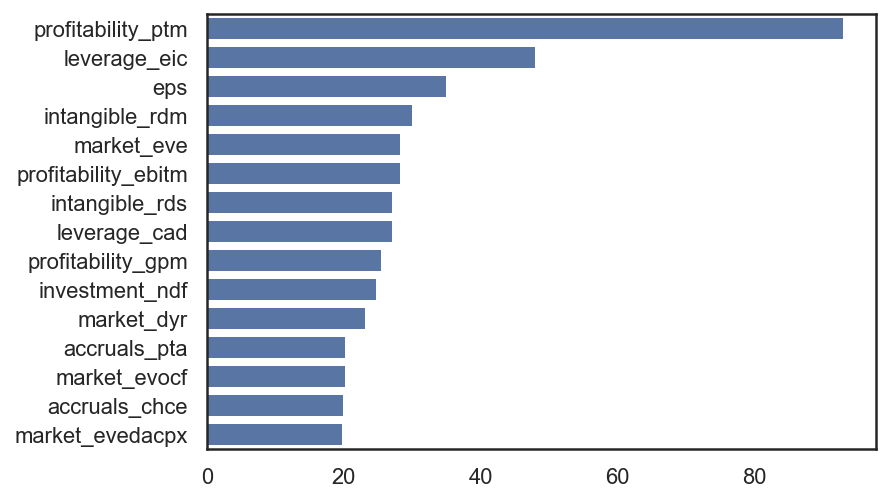

In [5]:
X_train, y_train, X_test, y_test = build_train_test(
    hydroxyibuprofen_features,
    hydroxyibuprofen_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2020-12-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only:
Max Drawdown: -1.5297062426688446
Sharpe : -0.5981088522887461
Total Return: -3.7063631171485016
Alpha: -0.61637504366327
Beta: -3.0634508653404264
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     142.4
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           3.08e-31
Time:                        12:07:07   Log-Likelihood:                 4162.9
No. Observations:                1319   AIC:                            -8322.
Df Residuals:                    1317   BIC:                            -8312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

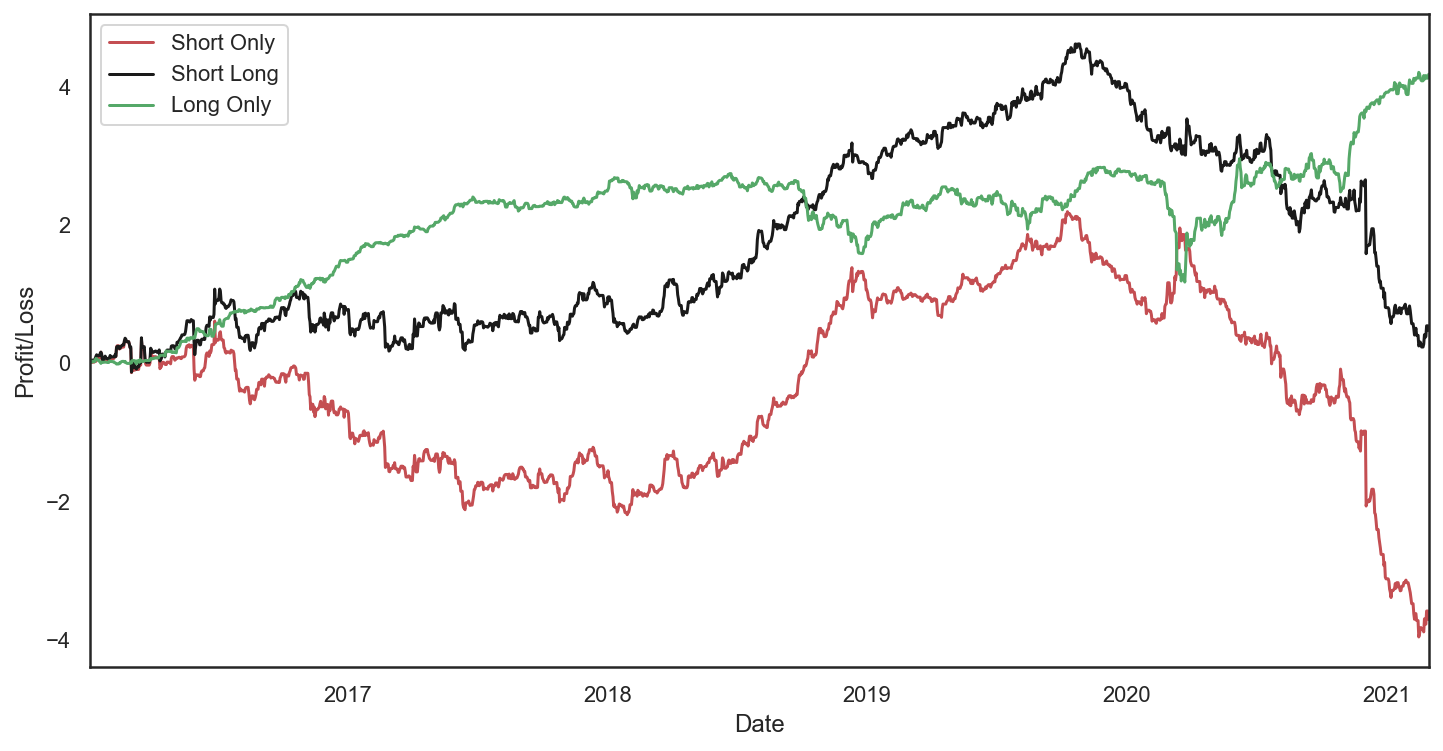

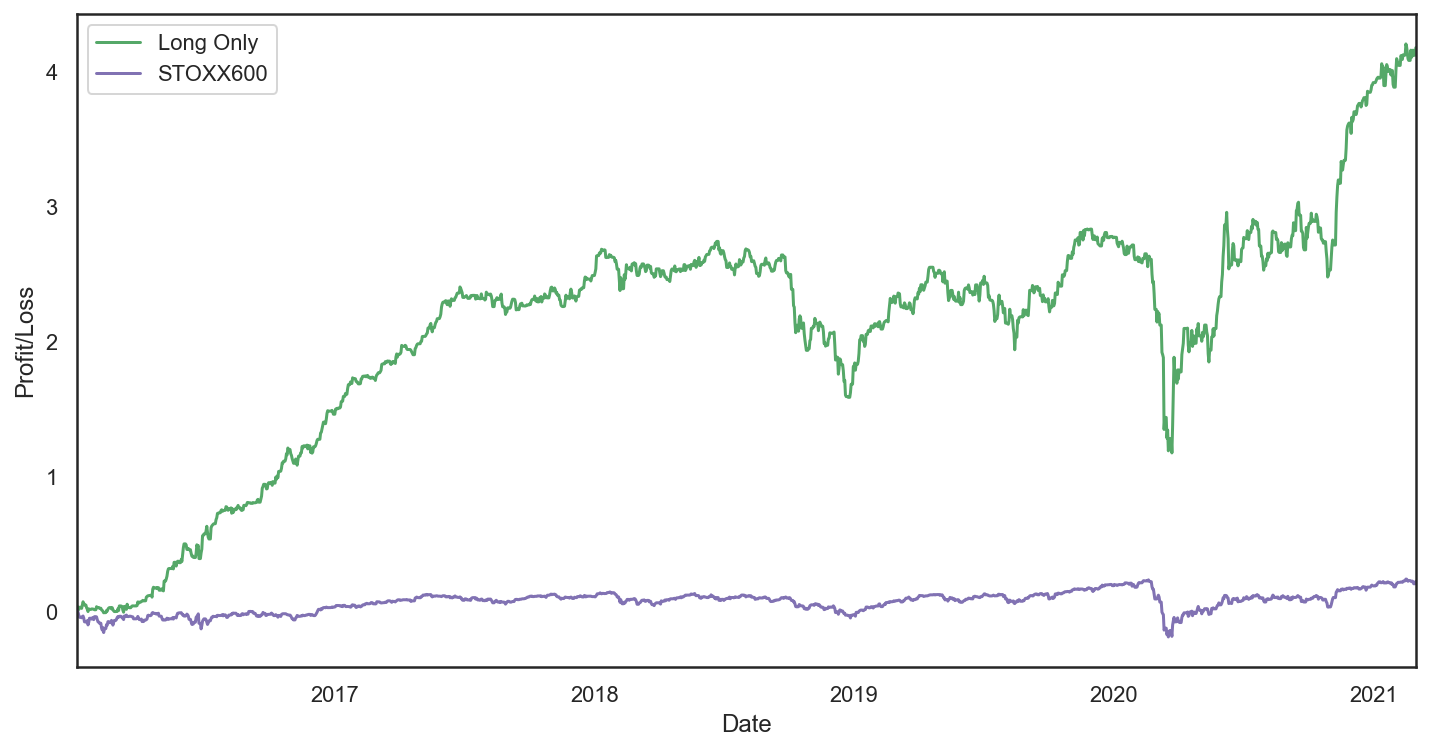

In [6]:
backtest_report(
    backtest_data,
    hydroxyibuprofen_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=30,
    weight="equal",
    method="percent")

### Ibuprofen
Ibuprofen is a factor investing strategy with Machine Learning.

In [7]:
def ibuprofen(df):
    df.eval(
        """
        intangible_rdm=xrd / mcap
        market_dyr=dvc * 10 ** 6 / cshoc / prccd
        market_pe=mcap / (nicon * 10 ** 6)
        market_pch=mcap / (oancf * 10 ** 6)
        market_ps=mcap / (revt * 10 ** 6)
        market_mb=mcap / (ceq * 10 ** 6)
        market_evs=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (revt * 10 ** 6)
        market_eveda=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebitda * 10 ** 6)
        market_eve=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / (ebit * 10 ** 6)
        market_evedacpx=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((ebitda - capx) * 10 ** 6)
        market_evocf=(mcap + (dlc + dltt + pstk + mib - chee) * 10 ** 6) / ((oancf) * 10 ** 6)
        """,
        inplace=True,
    )
    firm_factor = lambda df: df.assign(
        market_peg=(df.prccd / ((df.nicon * 10 ** 6) / df.cshoc)) / ((((df.nicon * 10 ** 6) / df.cshoc)/ (((df.nicon * 10 ** 6) / df.cshoc).shift(1))) - 1),
        hign_52w=1 - df.close/df.close.rolling(12).max(),
        mom_12m=df.close.shift(1)/df.close.shift(12) - 1,
        mom_6m=df.close.shift(1)/df.close.shift(6) - 1,
        mom_1m=df.close / df.close.shift(1) - 1,
        vol_12m=df.close.rolling(12).std(),
        vol_6m=df.close.rolling(6).std(),
        vol_3m=df.close.rolling(3).std(),
        )
    industry_factor=lambda df: df.assign(
        ind_mom_12m=df.mom_12m.mean(),
        ind_mom_6m=df.mom_6m.mean(),
        ind_mom_1m=df.mom_1m.mean(),
    )
    df = df.groupby(["gvkey"]).apply(firm_factor)
    df = df.groupby(["date", "sic"]).apply(industry_factor)
    return df.loc[(df.mcap > 1e6) & (df.prccd > 5),:].drop(columns=["country", "sic", "cshoc", "act", "att", "ap", "capx", "ceq", "ch", "che", "chee", "cogs", "dlc", "dltis", "dltr", "dltt", "dp", "dv", "dvc", "dvt", "dlcch", "ebit", "ebitda", "fincf", "gdwl", "icapt", "intan", "invt", "ivaeq", "ivao", "ivncf", "ivst", "lct", "ltt", "mib", "nicon", "oancf", "pi", "ppegt", "ppent", "pstk", "prstkc", "rect", "revt", "seq", "sstk", "teq", "txp", "xint", "xrd", "xsga", "prccd", "cshoc", "open", "high", "low", "close", "volume"])

In [8]:
ibuprofen_features = build_features(universe, ibuprofen, scale="rank")
ibuprofen_labels = build_labels(universe, months=3, relative=True)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.62      0.59      0.61     39168
           0       0.60      0.01      0.03      8054
           1       0.60      0.73      0.66     43029

    accuracy                           0.61     90251
   macro avg       0.61      0.45      0.43     90251
weighted avg       0.61      0.61      0.58     90251

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.25      0.48      0.33     13779
           0       0.81      0.01      0.01     45571
           1       0.20      0.65      0.31     14999

    accuracy                           0.22     74349
   macro avg       0.42      0.38      0.22     74349
weighted avg       0.58      0.22      0.13     74349



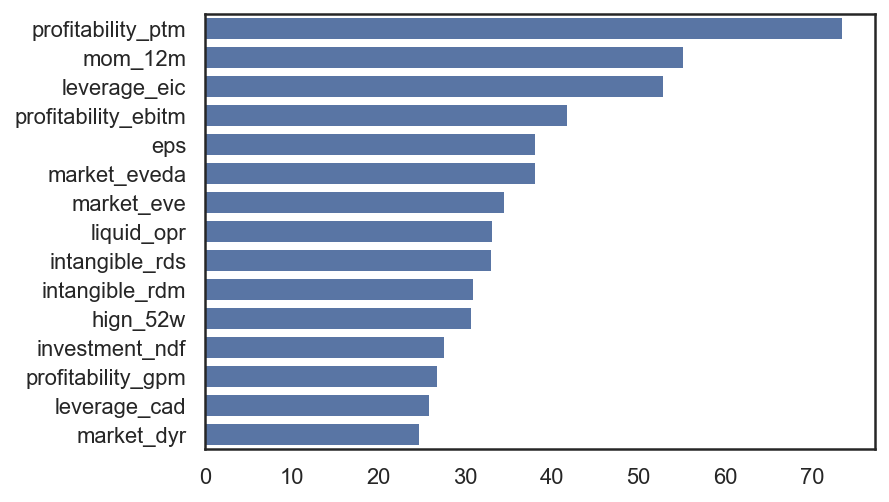

In [9]:
X_train, y_train, X_test, y_test = build_train_test(
    ibuprofen_features,
    ibuprofen_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2020-12-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:pure_factor_1\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only:
Max Drawdown: -0.4811603966913544
Sharpe : -0.6660032556141507
Total Return: -2.1560299447153772
Alpha: -0.351757367993302
Beta: -2.008925375371753
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     239.2
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           1.03e-49
Time:                        12:08:53   Log-Likelihood:                 4205.3
No. Observations:                1319   AIC:                            -8407.
Df Residuals:                    1317   BIC:                            -8396.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

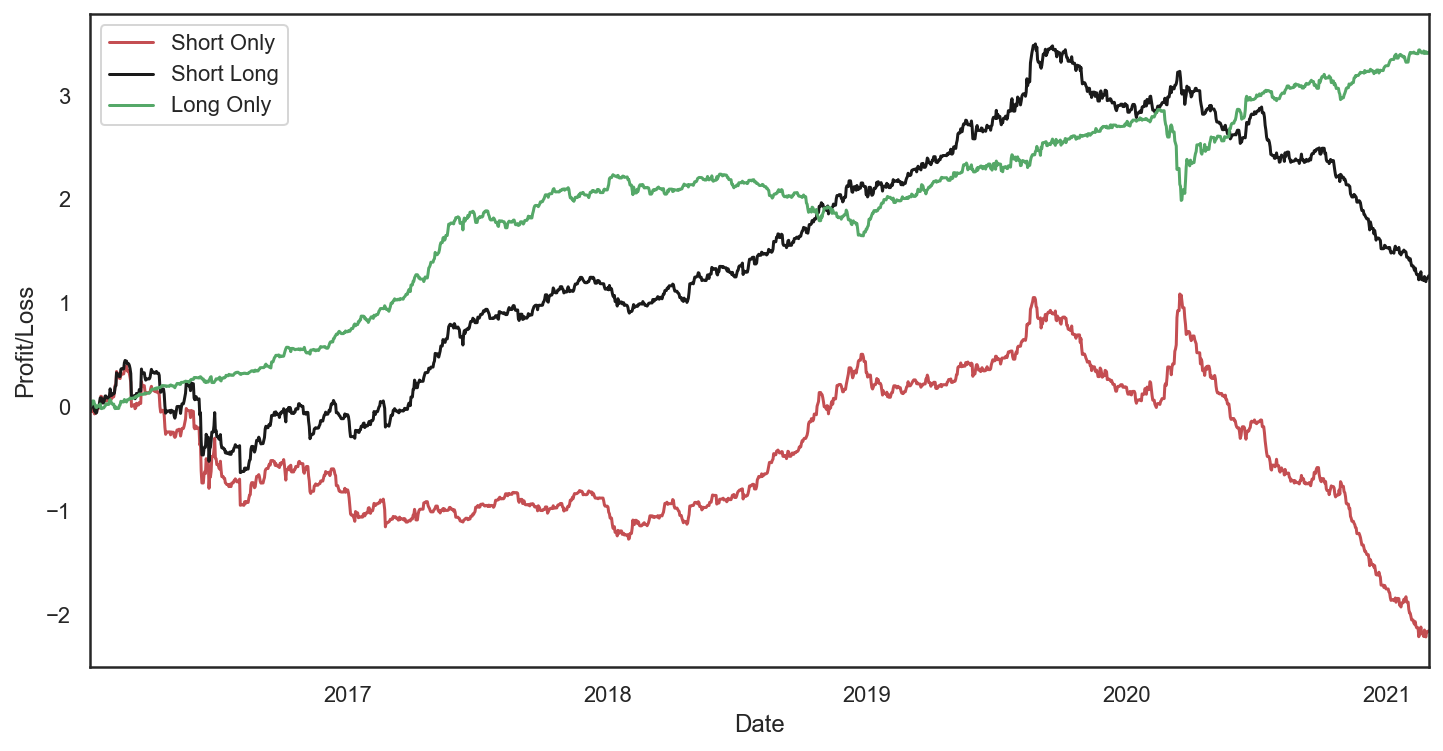

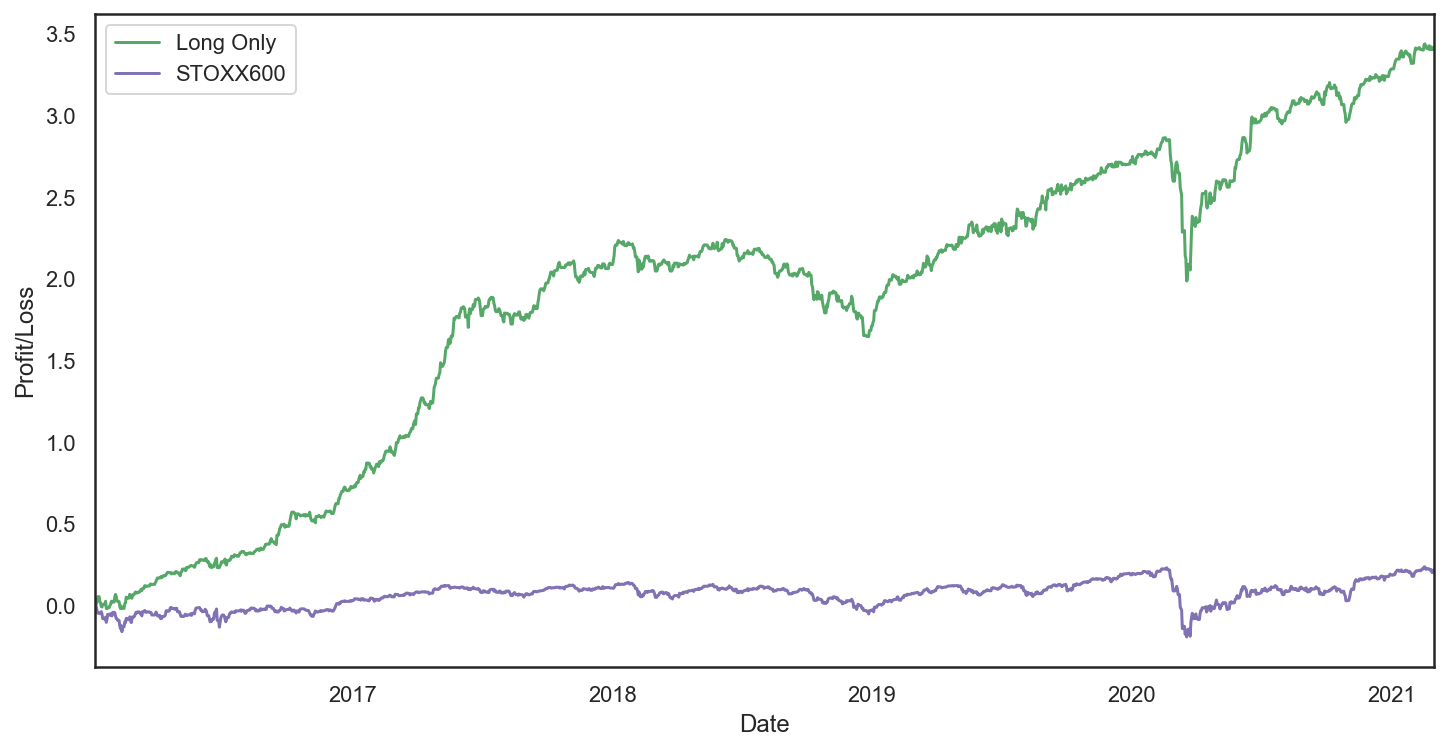

In [10]:
backtest_report(
    backtest_data,
    ibuprofen_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=20,
    weight="equal",
    method="percent")

## Technicals

### Techno
Techno is a strategy based purely on technical indicators.

In [11]:
def compute_rsi(data, window):
    diff = data.diff(1)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()
    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [12]:
def techno(df):
    windows = [3, 4, 5, 10, 20, 40]
    df["pct_1m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for window in windows:
        df[f"std_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).std())
        df[f"sh_{window}m"] = df.pct_1m.groupby("gvkey").transform(lambda x: x.rolling(window).mean() / x.rolling(window).std())
        df[f"pct_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(window - 1))
        df[f"ema_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=window, adjust=False).mean() -1 )
        df[f"qt_{window}m"] = df.close.groupby("gvkey").transform(lambda x: x.rolling(window).quantile(0.75) / x)
        df[f"scosc_{window}m"] = df.close.groupby("gvkey").transform(lambda x: (x - x.rolling(window).min()) / (x.rolling(window).max() - x.rolling(window).min()))
        df[f"rsi_{window}m"] = df.close.groupby("gvkey").transform(lambda x: compute_rsi(x, window))
    return df.loc[(df.mcap > 1e6) & (df.prccd>5), "high":].drop(columns=["volume", "close"]).dropna()

In [13]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw_data = pd.read_parquet("../data/raw-0.1.1.parquet")
gvkeys = raw_data[(raw_data.mcap > 1e6) & (raw_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw_data.loc[gvkeys]

In [14]:
techno_features = build_features(universe, techno, scale="rank")

In [15]:
techno_labels = build_labels(universe, months=3, relative=True)

In [16]:
X_train, y_train, X_test, y_test = build_train_test(
    techno_features,
    techno_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2016-01-01",
    test_end="2021-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.51      0.35      0.42     23507
           0       0.00      0.00      0.00      7766
           1       0.50      0.78      0.61     27591

    accuracy                           0.51     58864
   macro avg       0.34      0.38      0.34     58864
weighted avg       0.44      0.51      0.45     58864

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.24      0.32      0.28     10593
           0       0.00      0.00      0.00     37353
           1       0.20      0.76      0.32     12074

    accuracy                           0.21     60020
   macro avg       0.15      0.36      0.20     60020
weighted avg       0.08      0.21      0.11     60020



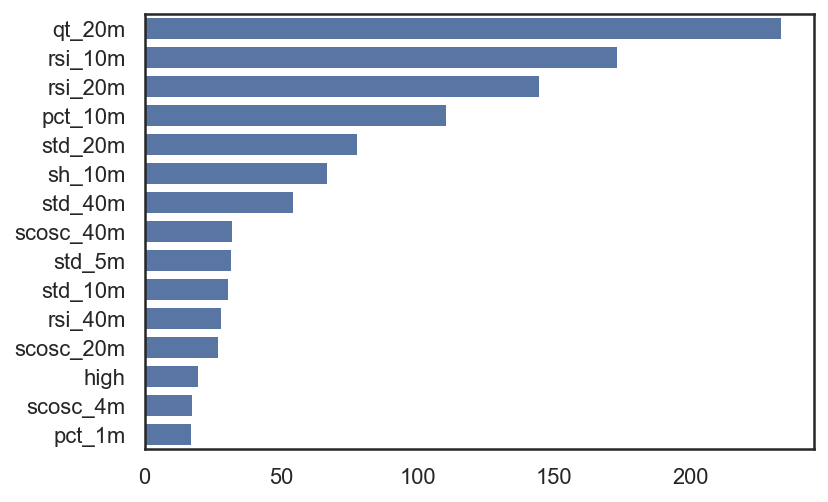

In [17]:
xgb_clf = XGBClassifier(n_estimators=100, 
                        max_depth=1, 
                        learning_rate=0.1, 
#                         eval_metric="logloss", 
                        class_weight='balanced',
                        verbosity=0,
                        n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).head(15)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only:
Max Drawdown: -0.976490722012832
Sharpe : -0.21103456608098248
Total Return: -0.9545516235221173
Alpha: -0.0813630137084845
Beta: -3.372932416310688
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     375.7
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           7.76e-74
Time:                        12:14:31   Log-Likelihood:                 4260.8
No. Observations:                1319   AIC:                            -8518.
Df Residuals:                    1317   BIC:                            -8507.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

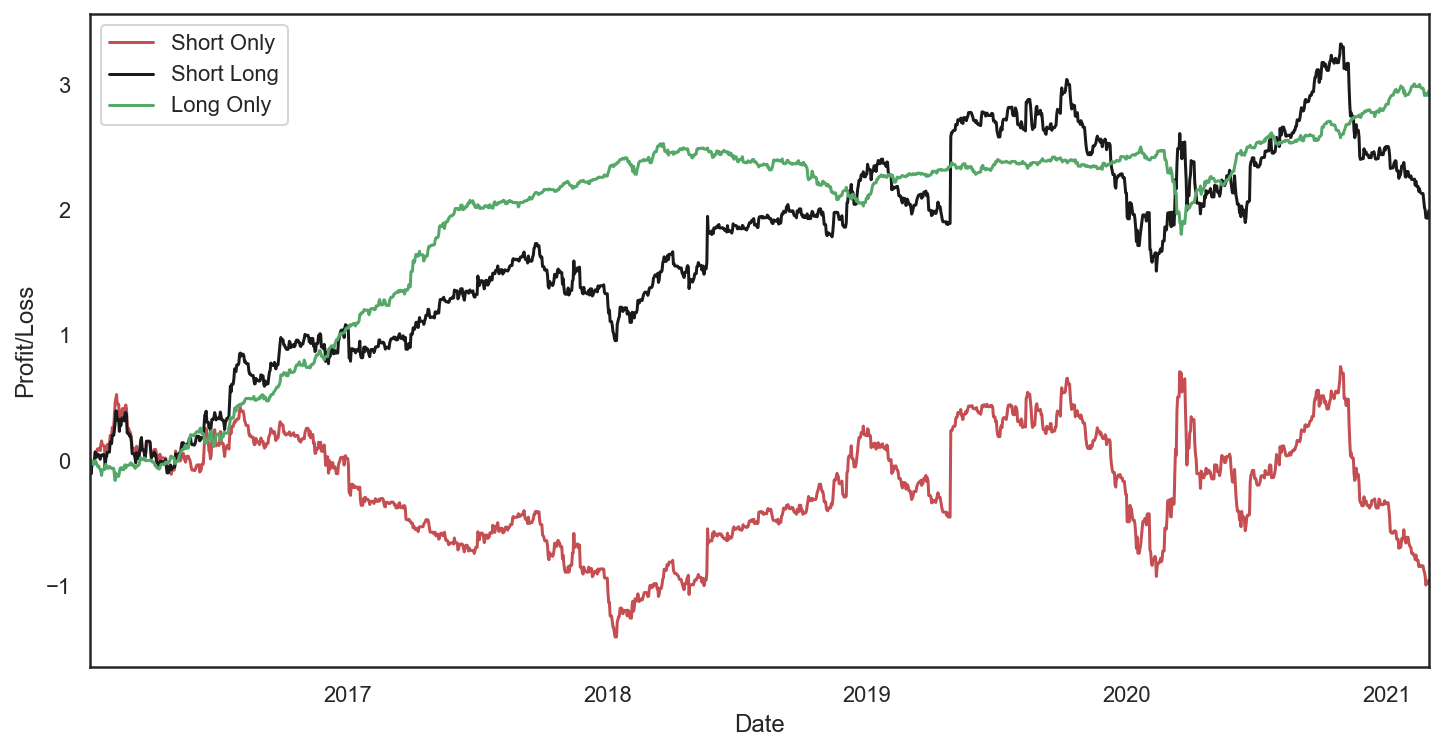

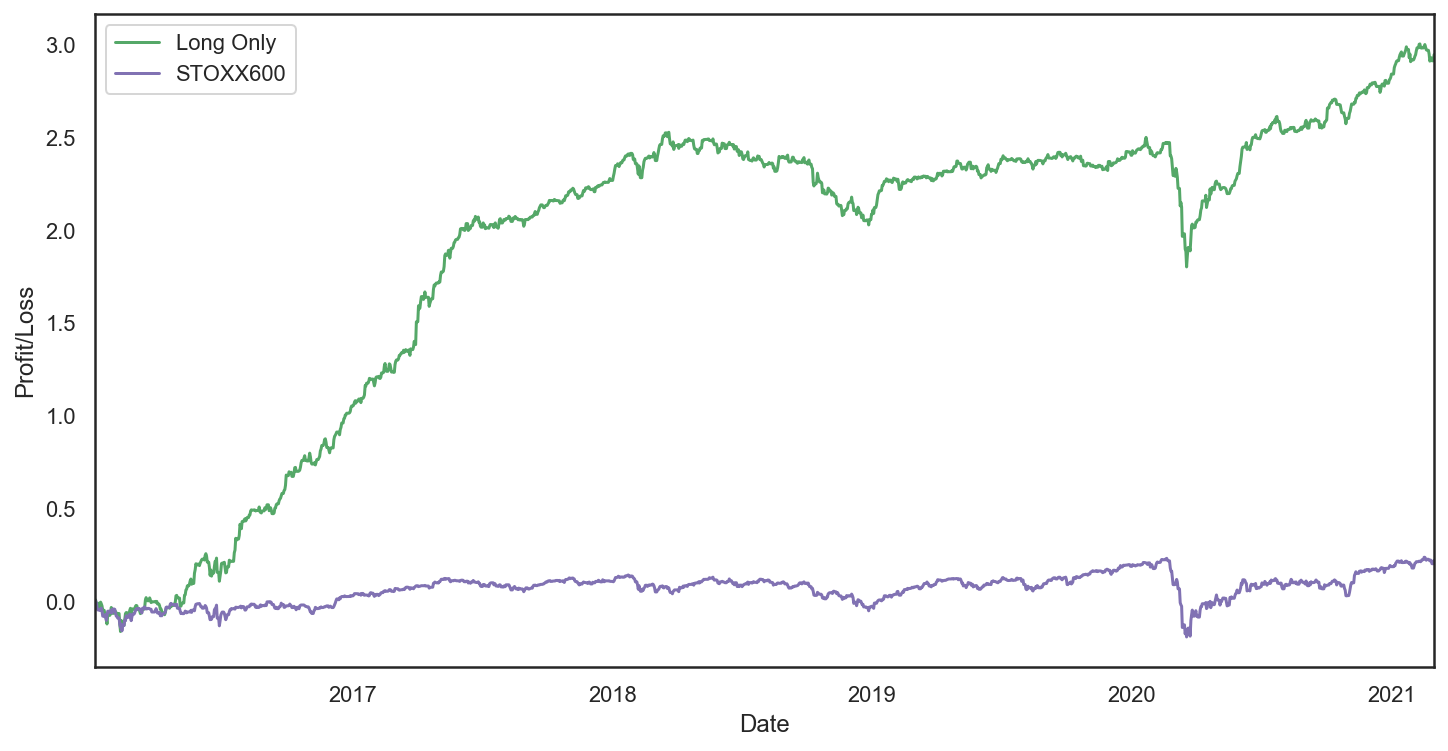

In [18]:
backtest_report(
    backtest_data,
    techno_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal")

## Analyst

### Superstition

Superstition is a strategy that blindly trusts analyst's estinmates and recommendations.

In [19]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw_data = pd.read_parquet("../data/raw-0.1.1.parquet")
gvkeys = raw_data[(raw_data.mcap > 1e6) & (raw_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw_data.loc[gvkeys]

In [20]:
def superstition(df):
    df.dropna(how="all", subset=["numest", "suescore", "medrec"], inplace=True)
    df.eval(
        """
        diff_high = (prccd - ptghigh) / prccd
        diff_med = (prccd - medptg) / prccd
        diff_low = (prccd - ptglow) / prccd
        """,
        inplace=True,
    )
    return df.loc[
        (df.mcap > 1e6) & (df.prccd > 5),
        ["numest",
        "numdown1m",
        "numup1m",
        "diff_high",
        "diff_med",
        "diff_low",
        "suescore",
        "medrec",
        "numdown",
        "numup",
        "numrec",
        "buypct",
        "holdpct",
        "sellpct",
        ],
    ]

In [21]:
superstition_features = build_features(universe, superstition, scale="rank")
superstition_labels = build_labels(universe, months=3, relative=True)

In [22]:
X_train, y_train, X_test, y_test = build_train_test(
    superstition_features,
    superstition_labels,
    train_start="2002-01-01",
    train_end="2016-01-01",
    test_start="2015-12-01",
    test_end="2020-12-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.56      0.48      0.52     27646
           0       1.00      0.00      0.00      5448
           1       0.54      0.70      0.61     29589

    accuracy                           0.55     62683
   macro avg       0.70      0.40      0.38     62683
weighted avg       0.59      0.55      0.52     62683

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.22      0.44      0.30      9332
           0       0.00      0.00      0.00     30137
           1       0.21      0.65      0.31      9972

    accuracy                           0.21     49441
   macro avg       0.14      0.36      0.20     49441
weighted avg       0.08      0.21      0.12     49441



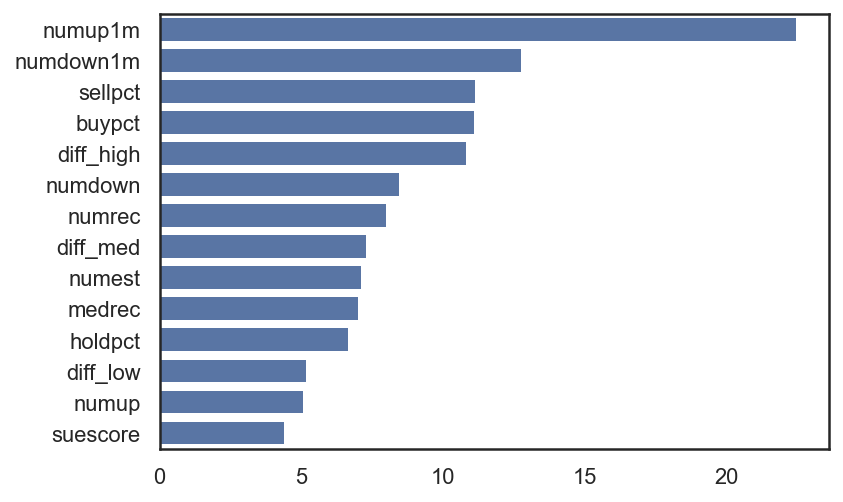

In [23]:
xgb_clf = XGBClassifier(n_estimators=10, max_depth=5, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only:
Max Drawdown: -0.5663851375339392
Sharpe : -0.17153073509122588
Total Return: -0.43713343520107434
Alpha: -0.00945745892109236
Beta: -2.4730237254656893
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     793.3
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          5.33e-137
Time:                        12:14:51   Log-Likelihood:                 4406.2
No. Observations:                1319   AIC:                            -8808.
Df Residuals:                    1317   BIC:                            -8798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t  

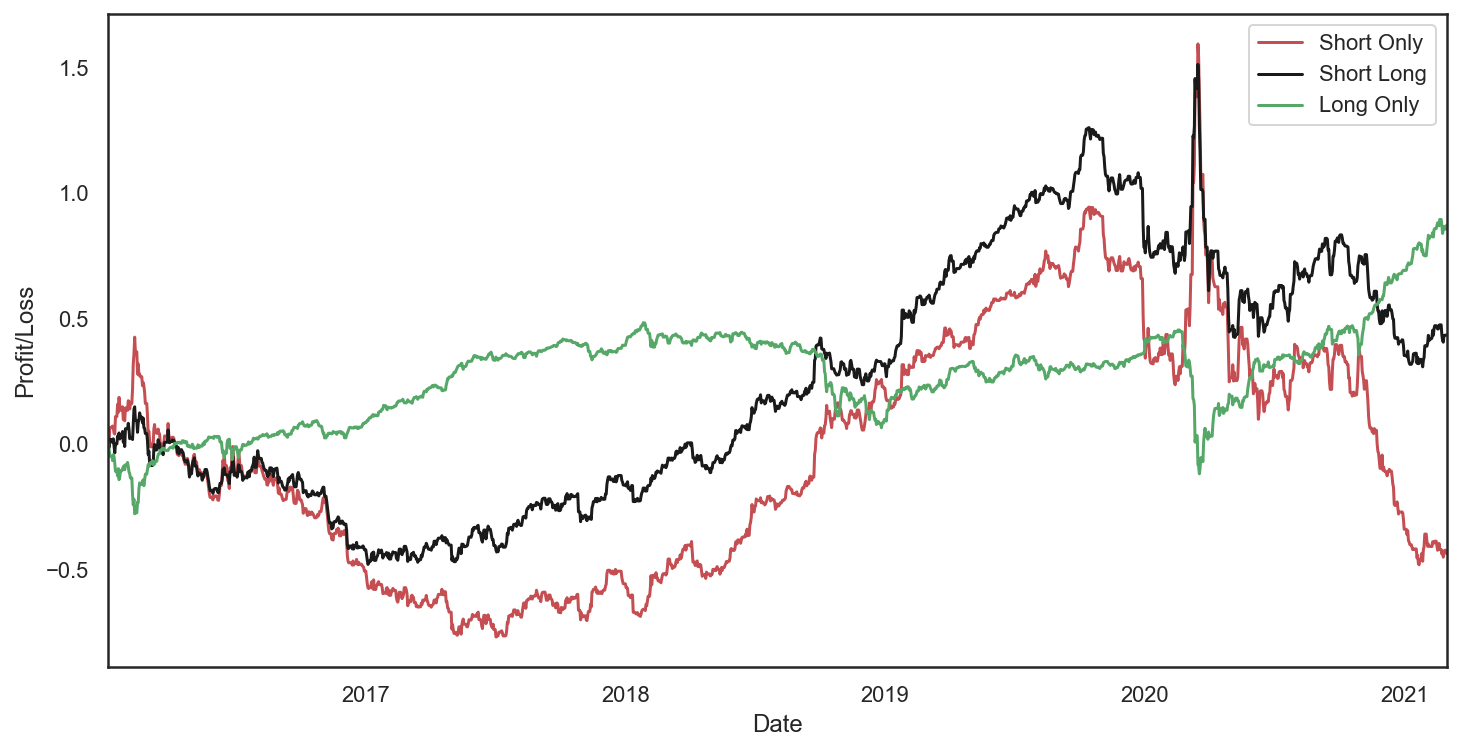

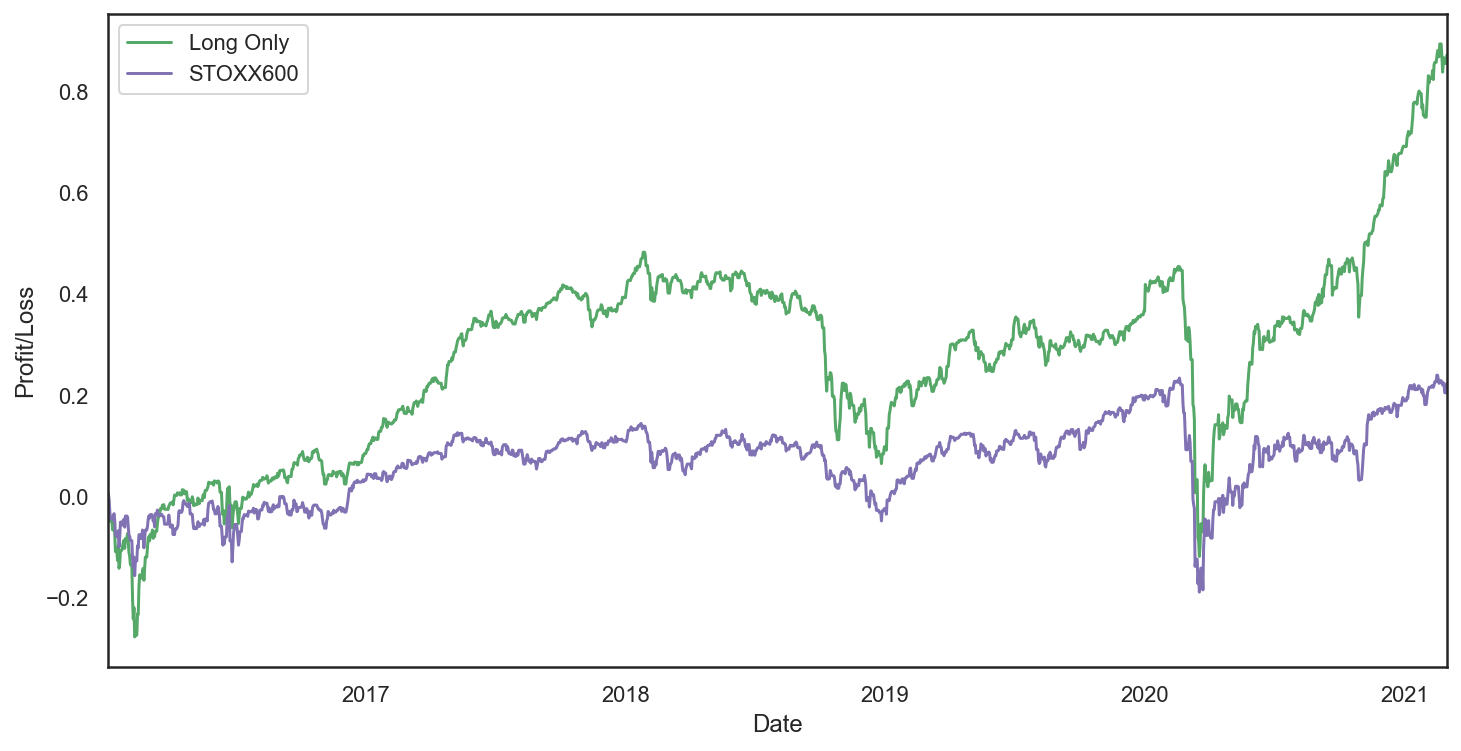

In [24]:
backtest_report(
    backtest_data,
    superstition_features,
    xgb_clf,
    test_start="2015-12-01",
    test_end="2021-03-01",
    months=3,
    n=10,
    weight="equal",
    method="percent")